* select playlist
* map each track to features
* preprocess
* make sequences

In [18]:
import json
import os
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Import data

In [ ]:
# Import all features and id to index mapping
all_features= torch.load('features_tensors.pt')

# Import ID to index map
with open("id_to_idx.json" , "r") as f:
    id_to_idx= json.load(f)

# Load playlists
with open("clean_playlists.json", "r") as f:
    playlists= json.load(f)

C:\Users\Thistle\AppData\Local\Temp\ipykernel_3264\2504704790.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_features= torch.load('features_tensors.pt')


In [ ]:
class preprocess:
    def __init__(self, filepath):
        playlists= self.load_playlists(filepath)

    def load_playlists(filepath = "clean_playlists.json"):
        """Load playlists from dataset"""
        with open(filepath, "r") as f:
            return  json.load(f)

    def get_ids_by_pid(pid):
        """Returns track IDs by playlist PID"""
        return playlists[pid]["tracks"]
    
    def get_name_by_pid(pid):
        """Returns playlist name/title by PID"""
        return playlists[pid]["name"]
    
    def get_ids_by_spotify():
        """Return  track IDs from spotify"""
        # Todo
        return None
    
    def get_name_by_spotify():
        """Return  track IDs from spotify"""
        # Todo
        return None
    
    def ids_to_features(ids, features):
        """Return list of features that correspond to provided IDs"""
        # Todo: either make it work with local storage first or make it work with pinecone straight ahead


In [ ]:


def get_playlist(pid):
    """ Returns playlist name and tracks by PID"""
    return playlists[pid]["name"], playlists[pid]["tracks"]

In [23]:
example_playlist= "980063"
playlist= get_playlist(example_playlist)
len(playlist[1])

41

In [24]:
def ids_to_features(ids):
    """ Map playlist IDs to corresponding features"""
    return [features.loc[features["track_id"] == id].drop(columns=["track_id"]).values[0] for id in ids]

playlist_features= ids_to_features(next(iter(playlists.values()))["tracks"] )
print(type(playlist_features[0]))

<class 'numpy.ndarray'>


In [25]:
def encode_and_normalise(playlist_name):
    """ Sentence Transform playlist name and normalise"""
    transformer = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings= transformer.encode(playlist_name)
    norm = np.linalg.norm(embeddings)
    return embeddings / norm if norm != 0 else embeddings

In [26]:
def preprocess_indiv_playlist(pid, sequence_length):
    """ Preprocess playlist into sequences and targets and name embeddings to be ready for the model
        args:
            pid: playlist id
    """

    # Get playlist by id
    playlist_name, track_ids= get_playlist(pid)

    # tracks ids to features idx map
    #id_to_idx= {track_id: idx for idx, track_id in enumerate(features["track_id"]) if track_id in track_ids}
    map= {k:v for k, v in id_to_idx.items() if k in track_ids}
    # Map IDs to features
    playlist_features= ids_to_features(map)

    # Make sequences and targets and embs
    sequences= []
    targets= []
    playlist_name_embs= encode_and_normalise(playlist_name)
    for i in range(len(playlist_features) - sequence_length):    
        input_sequence = [song_features for song_features in playlist_features[i:i + sequence_length]]
        sequence= np.array(input_sequence)
        sequences.append(sequence)

        target= playlist_features[i + sequence_length]
        targets.append(np.array(target))

    print(f"{len(sequences)} sequences made from '{playlist_name}' playlist")
    return (torch.tensor(np.array([playlist_name_embs for _ in range(len(sequences))]), dtype=torch.float32),
            torch.tensor(sequences, dtype=torch.float32),
            torch.tensor(targets, dtype=torch.float32),
            map)

In [27]:
embs, sequences, targets, playlist_id_to_idx= preprocess_indiv_playlist(example_playlist, 5)

36 sequences made from 'Gym' playlist


In [10]:
print(embs.shape)
print(sequences.shape)
print(targets.shape)

torch.Size([36, 384])
torch.Size([36, 5, 19, 384])
torch.Size([36, 19, 384])


In [28]:
import torch.nn as nn
# Defining RNN model with GRU and Soft Gating
class MusicRec(nn.Module):
    def __init__(self, target_feature_count= 19):
        super().__init__()
        self.target_feature_count= target_feature_count
        self.gru = nn.GRU(19*384, 512, batch_first=True)
        self.name_gate = nn.Linear(384, 19)  # 19 features to modulate
        self.head = nn.Sequential(
            nn.Dropout(0.3), # dropout for overfitting
            nn.Linear(512, target_feature_count * 384))  # Predict all features

    def forward(self, x, name_emb):
        # x: [batch, 5, 19, 384]
        # name_emb: [batch, 384]

        # Soft gating 
        gates= torch.sigmoid(self.name_gate(name_emb)) # [batch, 19]
        x = x * gates.unsqueeze(1).unsqueeze(-1)  # [batch, 5, 19, 384]

        # flatten x to [batch, 5, 19*384]
        x = x.flatten(2)  

        # Process sequence
        _, hidden = self.gru(x)
        
        pred = self.head(hidden.squeeze(0))  # [batch, 19*384]
        return pred.view(-1, self.target_feature_count, 384)  # Reshape to [batch, 19, 384]

In [29]:
# Load model state
# Config 
config = {
    "batch_size": 128,
    "lr": 3e-4,
    "epochs": 10,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}
model = MusicRec().to(config["device"])
model.load_state_dict(torch.load("best_model.pth"))


C:\Users\Thistle\AppData\Local\Temp\ipykernel_3264\696543663.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [31]:
def predict_playlist(model, input_windows, title_embs, targets):
    """
    Args:
        input_windows: [N, 5, 19, 384] tensor
        title_embs: [N, 384] tensor
        targets: [N, 19, 384] tensor (for evaluation)
    Returns:
        Dictionary of predictions and metrics
    """
    model.eval()
    results = {
        'predictions': [],
        'similarities': [],
        'mean_similarity': None
    }
    
    with torch.no_grad():
        for i in range(len(input_windows)):
            # Get batch (unsqueeze for batch dim)
            input_seq = input_windows[i].unsqueeze(0)  # [1, 5, 19, 384]
            title_emb = title_embs[i].unsqueeze(0)     # [1, 384]
            
            # Predict
            pred = model(input_seq, title_emb)  # [1, 19, 384]
            pred = pred.squeeze(0)              # [19, 384]
            
            # Store results
            results['predictions'].append(pred)
            
            # Calculate similarity if targets provided
            if targets is not None:
                sim = F.cosine_similarity(
                    pred.flatten(),
                    targets[i].flatten(),
                    dim=0
                ).item()
                results['similarities'].append(sim)
    
    if targets is not None:
        results['mean_similarity'] = np.mean(results['similarities'])
    
    return results


results = predict_playlist(model, sequences, embs, targets)

print(f"Average cosine similarity: {results['mean_similarity']:.3f}")
print(f"First prediction shape: {results['predictions'][0].shape}")

Average cosine similarity: 0.825
First prediction shape: torch.Size([19, 384])


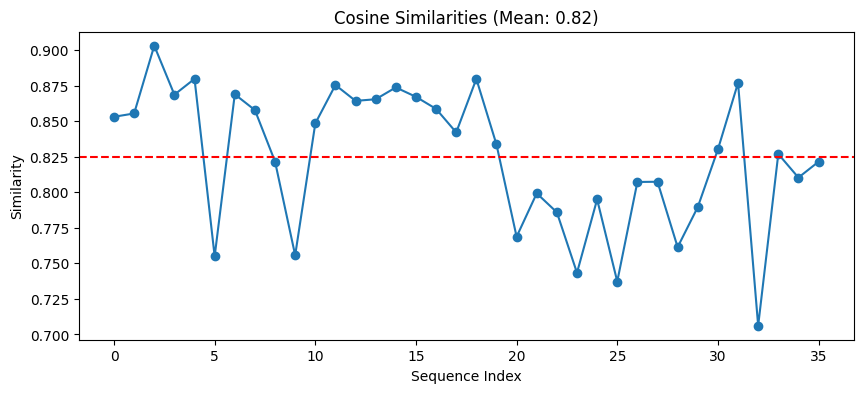

In [14]:
def plot_similarities(similarities):
    plt.figure(figsize=(10, 4))
    plt.plot(similarities, 'o-')
    plt.axhline(y=np.mean(similarities), color='r', linestyle='--')
    plt.title(f"Cosine Similarities (Mean: {np.mean(similarities):.2f})")
    plt.xlabel("Sequence Index")
    plt.ylabel("Similarity")
    plt.show()

# Usage:
plot_similarities(results['similarities'])

In [32]:
import torch
import pandas as pd
from torch.nn.functional import cosine_similarity

def find_closest_ids(predicted_features, all_features, features_ids, top_k=3):
    """
    Args:
        predicted_features: torch.Tensor of shape [19, 384]
        features_df: pd.DataFrame where:
            - First column: 'id' (song identifiers)
            - Next 19 columns: Feature arrays (each shape [384])
        top_k: Number of matches to return
    Returns:
        List of tuples (id, similarity_score) sorted by best matches
    """
    # Convert predicted features to normalized tensor
    pred_tensor = predicted_features.unsqueeze(0)  # [1, 19, 384]
    pred_tensor = torch.nn.functional.normalize(pred_tensor, dim=-1)

    # Normalize all features (L2 norm per 384-dim vector)
    all_features = F.normalize(all_features, dim=-1)  # Crucial for cosine similarity

    # Vectorized cosine similarity (batched)
    sims = (pred_tensor * all_features).sum(dim=-1)  # [100000, 19]
    mean_sims = sims.mean(dim=1)  # [100000]
    
    # Get top K matches
    top_indices = mean_sims.argsort(descending=True)[:top_k]
    return [(features_ids[i], mean_sims[i].item()) for i in top_indices]

similarities= find_closest_ids(results["predictions"][0], all_features, features_ids,3)

similarities

[('2aoo2jlRnM3A0NyLQqMN2f', 0.9122483134269714),
 ('7aySoZnwt7c6lA54qVVUOk', 0.9120509624481201),
 ('6R6ux6KaKrhAg2EIB2krdU', 0.9113379120826721)]

In [33]:
top_matches= find_closest_ids(results["predictions"][-1], all_features, features_ids, 3)

In [34]:
next_song_id = top_matches[0][0]
print(next_song_id)
print(list(playlist_id_to_idx.keys())[-1])

0343bYQtSfznf6v90jRLRK
2ZICF8SFI5tHttaLJKMY1X
